### Import Packages

In [37]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn

from utils.preprocess import getData
from utils.validate import validate
from networks.cnn import BasicCNN
import matplotlib.pyplot as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load, Preprocess Data


In [38]:
X_train, y_train, X_valid, y_valid, X_test, y_test, person_train, person_valid, person_test, mapToOriginal = getData(lib='torch')

### Shape of data

In [39]:
print('Training data shape: {}'.format(X_train.shape))
print('Valid data shape: {}'.format(X_valid.shape))
print('Test data shape: {}'.format(X_test.shape))

print('Training target shape: {}'.format(y_train.shape))
print('Valid target shape: {}'.format(y_valid.shape))
print('Test target shape: {}'.format(y_test.shape))

print('Training Persons shape: {}'.format(person_train.shape))
print('Valid Persons shape: {}'.format(person_valid.shape))
print('Test Persons shape: {}'.format(person_test.shape))




Training data shape: torch.Size([6960, 22, 250, 1])
Valid data shape: torch.Size([1500, 22, 250, 1])
Test data shape: torch.Size([1772, 22, 250, 1])
Training target shape: torch.Size([6960, 4])
Valid target shape: torch.Size([1500, 4])
Test target shape: torch.Size([1772, 4])
Training Persons shape: torch.Size([6960, 1])
Valid Persons shape: torch.Size([1500, 1])
Test Persons shape: torch.Size([1772, 1])


### Initialize Dataset and DataLoaders

In [11]:
batch_size=64
trainset = torch.utils.data.TensorDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

# Shuffle is set to false for validation and test sets since no training is done on them, all we do is evaluate.
valset =  torch.utils.data.TensorDataset(X_valid, y_valid)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

### Train a Convolutional Neural Network

In [12]:
# Initialize the network
network = BasicCNN()
print(network)

BasicCNN(
  (conv1): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0), dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(100, 200, kernel_size=(10, 1), str

In [13]:
# Select loss criterion
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

# Train the network
num_epochs = 5

# Store the loss
stats = {
    'train_accuracies': [],
    'train_losses': [],
    'val_accuracies': [],
    'val_losses': []
}

for epoch in range(num_epochs): # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
  
        # forward pass
        outputs = network(inputs)
        
        loss = criterion(outputs, labels)
        

        # backward + optimize
        loss.backward() # backward to get gradient values
        
        optimizer.step() # does the update
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # accumulate loss
        running_loss += loss.item()
        
        # Make prediction for batch
        _, predicted = outputs.max(1)
        
        # Store accuracy for batch
        # WE convert back from one-hot to integer for checking accuracy
        total += labels.size(0)
        correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
    # Store accuracy,loss for epoch
    train_loss=running_loss/len(trainloader)
    train_accuracy=100.*correct/total
    
    # At the end of each epoch, calculate validation accuracy
    
    # Set the network in eval mode since we're not training here
    network.eval()
    
     # Turn gradient computation off
    with torch.no_grad():
        val_accuracy, val_loss = validate(network, valloader, criterion)
    
    # Set the network back in training mode
    network.train()
    
    stats['train_accuracies'].append(train_accuracy)
    stats['train_losses'].append(train_loss)
    stats['val_accuracies'].append(val_accuracy)
    stats['val_losses'].append(val_loss)
    
    
    # Display results
    print(f'Epoch: {epoch}')
    print(f'\t -- Train Loss: {train_loss} | Train Accuracy: {train_accuracy}')
    print(f'\t -- Val Loss: {val_loss} | Val Accuracy: {val_accuracy}')

Epoch: 0
	 -- Train Loss: 3.225303022139663 | Train Accuracy: 41.89655172413793
	 -- Val Loss: 2.921672652165095 | Val Accuracy: 46.86666666666667
Epoch: 1
	 -- Train Loss: 2.727698183934623 | Train Accuracy: 56.508620689655174
	 -- Val Loss: 1.3984571422139804 | Val Accuracy: 64.06666666666666
Epoch: 2
	 -- Train Loss: 2.1566477221086484 | Train Accuracy: 65.12931034482759
	 -- Val Loss: 1.3841132546464603 | Val Accuracy: 69.73333333333333
Epoch: 3
	 -- Train Loss: 1.5795920890405637 | Train Accuracy: 71.92528735632185
	 -- Val Loss: 1.1612528612216313 | Val Accuracy: 74.26666666666667
Epoch: 4
	 -- Train Loss: 1.2209781126691661 | Train Accuracy: 77.25574712643679
	 -- Val Loss: 1.4357993677258492 | Val Accuracy: 71.86666666666666


### Plot training curves

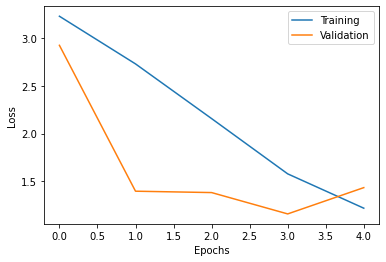

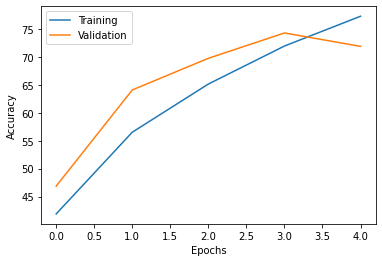

In [16]:
plt.figure()
plt.plot(np.arange(num_epochs), stats['train_losses'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_losses'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(num_epochs), stats['train_accuracies'], label='Training')
plt.plot(np.arange(num_epochs), stats['val_accuracies'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate on Test Set

In [17]:
# Set the network in eval mode since we're not training here
network.eval()

 # Turn gradient computation off
with torch.no_grad():
    test_accuracy, test_loss = validate(network, testloader, criterion)

# Set the network back in training mode
network.train()


print(f'Accuracy of the network on the {len(testloader.dataset)} test examples: {test_accuracy} %')

Accuracy of the network on the 1772 test examples: 52.99097065462754 %


### Save the model for inference or further training

In [18]:
path = "saved-models/basicCNN1.pth"
state = {
    'epoch': 5,
    'state_dict': network.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, path)